# Using Latent Class Analysis to explore (real) data

## Dan's Hypotheses
 - Adding back in some of the many and fewer hobbies people can be balanced with more classes, that tell us about the single minded obsessives and the butterfly try-everythingists.
 - Rather than looking for age and gender, I wonder if there's a picture to paint about sociability in hobbies.
 

In [102]:
from lca import LCA
import pandas as pd
import numpy as np


In [103]:
from plotly import __version__ as plotly_version
from plotly.offline import init_notebook_mode, iplot

print("Plotly version: " + plotly_version)

init_notebook_mode(connected=True)         # initiate notebook for offline plot

Plotly version: 3.5.0


# Introducing the data

We work with some data about which hobbies people have, from the "2003 INSEE survey on identity construction". The data concerns 8,403 individuals and includes Yes/No answers to "Which of the following leisure activities do you practice regularly" for 17 hobbies.

There are also some extra data: number of hours of TV per day on average, gender, age band, profession and marital status.

We also have a convenience column saying how many activities they answered yes to.

In [170]:
hobby_cols = [
    'Reading',
    'ListeningToMusic',
    'Cinema',
    'Show',
    'Exhibition',
    'Computer',
    'Sport',
    'Walking',
    'Travelling',
    'PlayingMusic',
    'Collecting',
    'Volunteering',
    'Mechanic',
    'Gardening',
    'Knitting',
    'Cooking',
    'Fishing',
]

data_df = pd.read_csv("hobbies.csv", sep=";")

for col in hobby_cols:
    data_df[col] = data_df[col].apply(lambda x: 1 if x == 'y' else 0)
print('there are', len(data_df), 'rows')    
data_df.head(10)

there are 8403 rows


,Reading,ListeningToMusic,Cinema,Show,Exhibition,Computer,Sport,Walking,Travelling,PlayingMusic,...,Gardening,Knitting,Cooking,Fishing,TV,Sex,AgeBand,MaritalStatus,Profession,NumActivities
0,1,1,1,1,1,0,1,1,1,0,...,0,0,0,0,2,F,"(55,65]",Married,Management,11
1,1,0,0,0,1,0,1,1,0,0,...,1,0,0,0,4,M,"(45,55]",Married,NaN,9
2,1,1,0,0,1,0,0,0,1,0,...,0,0,0,0,4,F,"(25,35]",Remarried,Management,5
3,1,0,0,0,1,0,1,0,1,0,...,0,0,0,0,1,M,"(75,85]",Married,NaN,5
4,1,1,1,1,0,0,0,1,0,0,...,0,0,0,0,3,M,"(55,65]",Married,Employee,6
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,M,"(45,55]",Married,Manual labourer,2
6,0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,3,M,"(35,45]",Married,Employee,5
7,1,1,1,1,1,1,0,0,1,0,...,0,0,0,0,0,M,"[15,25]",Single,NaN,7
8,1,1,1,1,0,1,1,1,1,1,...,0,0,0,0,1,F,"(35,45]",Single,Management,10
9,1,1,1,0,1,0,0,0,0,1,...,1,0,0,0,1,F,"(25,35]",Single,Employee,8


I'm going to simplify some of the meta data for later...

In [171]:
data_df['MaritalStatus'].unique()

array(['Married', 'Remarried', 'Single', 'Divorcee', 'Widower'],
      dtype=object)

In [172]:
data_df['Profession'].unique()

array(['Management', nan, 'Employee', 'Manual labourer', 'Foreman',
       'Other', 'Unskilled worker', 'Technician'], dtype=object)

In [173]:
age_ests = {
    "[15,25]": 20,
    "(25,35]": 30,
    "(35,45]": 40,
    "(45,55]": 50,
    "(55,65]": 60,
    "(65,75]": 70,
    "(75,85]": 80,
    "(85,100]": 92.5
}

data_df['Age'] = data_df['AgeBand'].map(age_ests)

partnered_ests = {
    'Single': 0,
    'Divorcee': 0,
    'Widower': 0,
    'Married': 1,
    'Remarried': 1,
    
}
data_df['Partnered'] = data_df['MaritalStatus'].map(partnered_ests)

has_job_ests = {
    np.nan: 0,
    'Management': 1, 
    'Employee': 1, 
    'Manual labourer': 1, 
    'Foreman': 1, 
    'Other': 1, 
    'Unskilled worker': 1, 
    'Technician': 1, 
}

data_df['Has_Job'] = data_df['Profession'].map(has_job_ests)

male_female_asnum = {
    'M': 0,
    'F': 1,
}
data_df['FemaleFlag'] = data_df['Sex'].map(male_female_asnum)

In [174]:
# TV watching wasn't falling out as a latent property, and is arguably a hobby.
tv_hours_median = data_df.TV.median()
tv_hours_mean = data_df.TV.mean()
tv_hours_sd = data_df.TV.std()

# very little predictive power in the median
# data_df['TV_Watcher'] = data_df['TV'].map(lambda h: 1 if h >= tv_hours_median else 0)
# hobby_cols.append('TV_Watcher')

data_df['Square_Eyed'] = data_df['TV'].map(lambda h: 1 if h > (tv_hours_mean) else 0)
hobby_cols.append('Square_Eyed')

tv_hours_median, tv_hours_mean, tv_hours_mean + tv_hours_sd

(2.0, 2.3548732595501605, 3.688156561496673)

In [175]:
data_df.head(10)

,Reading,ListeningToMusic,Cinema,Show,Exhibition,Computer,Sport,Walking,Travelling,PlayingMusic,...,Sex,AgeBand,MaritalStatus,Profession,NumActivities,Age,Partnered,Has_Job,FemaleFlag,Square_Eyed
0,1,1,1,1,1,0,1,1,1,0,...,F,"(55,65]",Married,Management,11,60.0,1,1,1,0
1,1,0,0,0,1,0,1,1,0,0,...,M,"(45,55]",Married,NaN,9,50.0,1,0,0,1
2,1,1,0,0,1,0,0,0,1,0,...,F,"(25,35]",Remarried,Management,5,30.0,1,1,1,1
3,1,0,0,0,1,0,1,0,1,0,...,M,"(75,85]",Married,NaN,5,80.0,1,0,0,0
4,1,1,1,1,0,0,0,1,0,0,...,M,"(55,65]",Married,Employee,6,60.0,1,1,0,1
5,0,0,0,0,0,0,0,0,0,0,...,M,"(45,55]",Married,Manual labourer,2,50.0,1,1,0,1
6,0,1,0,0,0,1,1,0,0,0,...,M,"(35,45]",Married,Employee,5,40.0,1,1,0,1
7,1,1,1,1,1,1,0,0,1,0,...,M,"[15,25]",Single,NaN,7,20.0,0,0,0,0
8,1,1,1,1,0,1,1,1,1,1,...,F,"(35,45]",Single,Management,10,40.0,0,1,1,0
9,1,1,1,0,1,0,0,0,0,1,...,F,"(25,35]",Single,Employee,8,30.0,0,1,1,0


# What kinds of people are there?


Our question is: **What different kinds of people are there (as far as hobbies are concerned)?**
**Can we divide people into groups based on their hobbies?** This is an example of **unsupervised learning**.

The idea is that the population is composed of a number of different classes of people, and people from different classes tend to prefer different hobbies.

But we can't observe the classes of people directly (they are "Latent"); we can only infer their existence from the hobbies data.

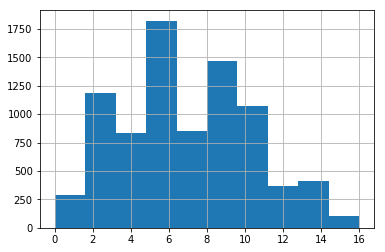

In [176]:
%matplotlib inline
data_df.NumActivities.hist()

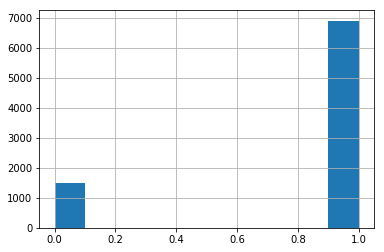

In [177]:
data_df.Has_Job.hist()

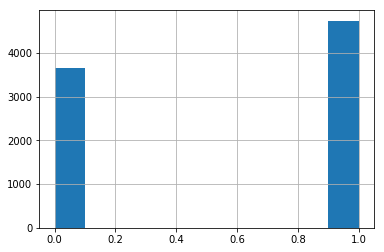

In [178]:
data_df.Partnered.hist()

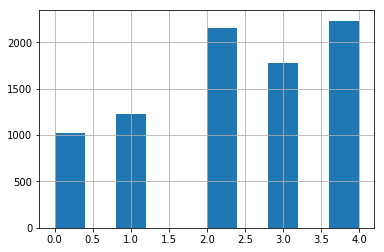

In [179]:
data_df.TV.hist()

In [180]:
print("originally there are", len(data_df), 'rows in the data frame')
reduced_data_df = data_df.loc[data_df['NumActivities'].isin(range(1, len(hobby_cols) - 1))]
print("Cut down to data for %d people." % reduced_data_df.shape[0])

originally there are 8403 rows in the data frame
Cut down to data for 8362 people.


In [181]:
data_df = reduced_data_df

Let's get a matrix of just the hobbies responses.

In [182]:
matrix = data_df[hobby_cols].values.copy()
matrix

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 1, 0, 0]])

The LCA routine will find the latent classes for us, but we need to (or, we get to) say how many we want.

In [183]:
num_classes = 5

Let's do the business:

In [184]:
lca = LCA(n_components=num_classes)
lca.fit(matrix)

print("Finished finding latent classes.")

Finished finding latent classes.


In [185]:
def nice_prob_df_for_class(num_classes, lca, chosen_class):
    
    probs_df = pd.DataFrame(hobby_cols, columns=['Hobby'])

    for i in range(num_classes):
        probs_df['Class%dProb' % i] = lca.theta[i, :]

        
    # Find the average probability for all classes except the chosen class:
    
    other_class_probs = [probs_df['Class%dProb' % i] for i in range(num_classes) if i != chosen_class]

    total_prob_other_classes = other_class_probs[0]

    for col in other_class_probs[1:]:
        total_prob_other_classes = total_prob_other_classes + col  # Here we exploit the fact that you can add two Pandas series.
    
    probs_df['AvgOtherProb'] = total_prob_other_classes / (num_classes - 1)
    
    
    probs_df['Ratio'] = probs_df['Class%dProb' % chosen_class] / probs_df['AvgOtherProb']
    probs_df = probs_df.sort_values('Ratio', ascending=False)
    
    return probs_df

In [186]:
for i in range(num_classes):
    probs_df = nice_prob_df_for_class(num_classes, lca, i)
    chart_data = []

    for i in range(num_classes):
        chart_data.append({
            'x': probs_df['Hobby'],
            'y': probs_df['Class%dProb' % i],
            'type': 'bar',
            'name': "Class %d (%.1f%%)" % (i, lca.weight[i] * 100)
        })

    figure = {
        'data': chart_data,
        'layout': {'yaxis': {'title': 'Probability of hobby'}}
    }

    iplot(figure)

In [187]:
data_df['PredictedClass'] = lca.predict(matrix)  # Hard assignment

soft_assignment = lca.predict_proba(matrix)

for i in range(num_classes):
    data_df['Class%dProb' % i] = soft_assignment[:,i]

data_df.head(10)

,Reading,ListeningToMusic,Cinema,Show,Exhibition,Computer,Sport,Walking,Travelling,PlayingMusic,...,Partnered,Has_Job,FemaleFlag,Square_Eyed,PredictedClass,Class0Prob,Class1Prob,Class2Prob,Class3Prob,Class4Prob
0,1,1,1,1,1,0,1,1,1,0,...,1,1,1,0,1,0.003949,9.853796e-01,0.002659,0.008012,1.577894e-07
1,1,0,0,0,1,0,1,1,0,0,...,1,0,0,1,2,0.244823,3.370700e-03,0.749243,0.001026,1.536818e-03
2,1,1,0,0,1,0,0,0,1,0,...,1,1,1,1,3,0.309424,3.050563e-03,0.018902,0.512675,1.559484e-01
3,1,0,0,0,1,0,1,0,1,0,...,1,0,0,0,3,0.157241,2.285165e-03,0.083154,0.607000,1.503193e-01
4,1,1,1,1,0,0,0,1,0,0,...,1,1,0,1,3,0.087978,9.362101e-03,0.008481,0.873880,2.029832e-02
5,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,4,0.000561,2.085460e-08,0.012396,0.003351,9.836928e-01
6,0,1,0,0,0,1,1,0,0,0,...,1,1,0,1,3,0.004627,1.909962e-04,0.257323,0.657076,8.078336e-02
7,1,1,1,1,1,1,0,0,1,0,...,0,0,0,0,3,0.011782,3.149442e-01,0.001584,0.671677,1.249074e-05
8,1,1,1,1,0,1,1,1,1,1,...,0,1,1,0,1,0.002349,7.669219e-01,0.000600,0.230129,5.547641e-07
9,1,1,1,0,1,0,0,0,0,1,...,0,1,1,0,0,0.391657,1.612121e-01,0.319269,0.124743,3.118490e-03


## How Does This Relate To Other Properties?

In [188]:
for i in range(num_classes):
    print(f"Mean number of activities in class {i}: {data_df.loc[data_df['PredictedClass'] == i]['NumActivities'].mean():.1f}")


Mean number of activities in class 0: 8.1
Mean number of activities in class 1: 11.5
Mean number of activities in class 2: 7.4
Mean number of activities in class 3: 6.3
Mean number of activities in class 4: 3.4


In [189]:
for i in range(num_classes):
    print(f"Chance of being partnered in class {i}: {data_df.loc[data_df['PredictedClass'] == i]['Partnered'].mean():.1f}")


Chance of being partnered in class 0: 0.6
Chance of being partnered in class 1: 0.5
Chance of being partnered in class 2: 0.7
Chance of being partnered in class 3: 0.4
Chance of being partnered in class 4: 0.6


In [190]:
for i in range(num_classes):
    print(f"Chance of having a job in class {i}: {data_df.loc[data_df['PredictedClass'] == i]['Has_Job'].mean():.2f}")


Chance of having a job in class 0: 0.85
Chance of having a job in class 1: 0.84
Chance of having a job in class 2: 0.89
Chance of having a job in class 3: 0.79
Chance of having a job in class 4: 0.79


In [191]:
for i in range(num_classes):
    print(f"Proportion has a job or partnered {i}: {(data_df.loc[data_df['PredictedClass'] == i]['Has_Job'] + data_df.loc[data_df['PredictedClass'] == i]['Partnered']).mean():.2f}")


Proportion has a job or partnered 0: 1.49
Proportion has a job or partnered 1: 1.35
Proportion has a job or partnered 2: 1.59
Proportion has a job or partnered 3: 1.19
Proportion has a job or partnered 4: 1.40


In [192]:
for i in range(num_classes):
    print(f"Mean age in class {i}: {data_df.loc[data_df['PredictedClass'] == i]['Age'].mean():.1f}")


Mean age in class 0: 53.5
Mean age in class 1: 41.1
Mean age in class 2: 47.4
Mean age in class 3: 37.1
Mean age in class 4: 55.8


In [196]:
for i in range(num_classes):
    print(f"Std Deviation age in class {i}: {data_df.loc[data_df['PredictedClass'] == i]['Age'].std():.1f}")


Std Deviation age in class 0: 14.6
Std Deviation age in class 1: 14.0
Std Deviation age in class 2: 14.3
Std Deviation age in class 3: 15.7
Std Deviation age in class 4: 17.1


In [193]:
for i in range(num_classes):
    print(f"Proportion of women in class {i}: {data_df.loc[data_df['PredictedClass'] == i]['FemaleFlag'].mean():.1f}")


Proportion of women in class 0: 0.8
Proportion of women in class 1: 0.6
Proportion of women in class 2: 0.2
Proportion of women in class 3: 0.5
Proportion of women in class 4: 0.6


Manual guesses from histograms:
 - 0 - knitting, collecting, cooking, gardening, exhibition, walking, reading, tv - stereotypes are older women
 - 1 - show, playing music, exhibition, cinema, travelling, volunteering, sport: stereotypes are gregarious, going  -out activities.
 - 2 - fishing, mechanic, gardening, volunteering, collecting, walking, sport: stereotypes are older men
 - 3 - cinema, computer, sport, music, show, reading ... maybe younger rather than a preference for a type of activity?
 - 4 - tv is top, then maybe knitting fishing and gardening but most of the bars are around the smallest - doesn't do much, likely oldest

Observations from biases in meta-data:

 - Class 4 is "doesn't do much", and class 1 is "does lots of things".

 - Classes 3 and 1 are younger, classes 0 and 4 are older, but class 4 less clearly so.

 - Class 3 is more likely to be single, class 2 is least likely to be single.

 - Class 2 is more likely to have a job, classes 3 and 4 least likely - but fairly marginal.

 - We might expect class 3 (and then 1) to have fewer human interactions from home and work, classes 0 and 2 the most.

 - Class 0 is skewed to female; class 2 is skewed to male.

## Footnote

If we want to check convergence of the algorithm (that we ran it for enough iterations) we can do that as follows.
If the line has not flattened out, then you can add more iterations using the `max_iter` argument to `LCA`.

In [194]:
figure = {
    'data': [
        {
           'x': list(range(1, len(lca.ll_))),
           'y': lca.ll_[1:]
        }],
    
    'layout': {
        'xaxis': { 'title': 'Iteration number' },
        'yaxis': { 'title': 'Log likelihood' }
        }
}

iplot(figure)

## Exercise 1

Apply the above approach to 4 clusters. For the clusters you get, try to arrive at a rough caricature of what somebody in that cluster looks like, based on the hobbies that people in that cluster typically do (and don't do), and what the data in the extra columns (hours of TV viewing, gender, age band, profession and marital status) looks like.


## Bonus Exercise (potentially time-consuming)

Run LCA on some different data. You could try for example:
 - Take the above data, and derive some extra attributes from the columns we didn't use (number of hours of TV per day, gender, age band, profession and marital status); see how putting these into the model rather than just analysing them afterwards changes the results.
 - Take a set of mention snippets (or news headlines) from a query and form Boolean attributes from the presence/absence of particular words.
 - Take some audiences data and use the interests or conversation topics as your attributes.
 - Take some data from a forum like MumsNet or Reddit and use the subforums as your attributes (with value 1 if a person posted on that subforum, and value 0 if they didn't).